# Brain MRI Tumor Segmentation Assignment
## Otsu vs Sauvola Comparison

Deadline: 13th Feb
Dataset: Kaggle Brain MRI Tumor Dataset
Task: Segment tumor region in MRI slices
Methods: Global Otsu vs Sauvola adaptive threshold
Compare: Dice score, Jaccard

## 1. Imports

In [ ]:

!pip install opencv-python scikit-image matplotlib numpy pandas

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects, binary_closing, disk
from pathlib import Path
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)

## 2. Segmentation Functions

In [3]:
# Preprocessing function
def preprocess(img):
    # convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    
    return enhanced

# Otsu segmentation
def segment_otsu(img):
    # get threshold value
    thresh = threshold_otsu(img)
    
    # apply threshold
    binary = img > thresh
    
    # clean up small objects
    binary = remove_small_objects(binary, min_size=100)
    binary = binary_closing(binary, disk(3))
    
    return binary.astype(np.uint8) * 255

# Sauvola segmentation
def segment_sauvola(img, window_size=25, k=0.3):
    # get threshold map
    thresh = threshold_sauvola(img, window_size=window_size, k=k)
    
    # apply threshold
    binary = img > thresh
    
    # clean up
    binary = remove_small_objects(binary, min_size=100)
    binary = binary_closing(binary, disk(3))
    
    return binary.astype(np.uint8) * 255

# Dice coefficient
def dice_score(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    intersection = np.logical_and(mask1, mask2).sum()
    total = mask1.sum() + mask2.sum()
    
    if total == 0:
        return 1.0
    
    return (2.0 * intersection) / total

# Jaccard index
def jaccard(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return 1.0
    
    return intersection / union

print("Functions defined")

Functions defined


## 3. Test on Single Image

In [4]:
# test on one image first
base_dir = '/home/patan/Downloads/archive'
test_folder = os.path.join(base_dir, 'Training', 'glioma')
image_files = [f for f in os.listdir(test_folder) if f.endswith('.jpg')]
test_image_path = os.path.join(test_folder, image_files[0])

print(f"Testing on: {image_files[0]}")

Testing on: Tr-gl_0280.jpg


## 4. Process and Compare

Image shape: (512, 512, 3)

Results:
Otsu - Dice: 1.0000, Jaccard: 1.0000
Sauvola - Dice: 0.5795, Jaccard: 0.4080
Agreement - Dice: 0.5795, Jaccard: 0.4080


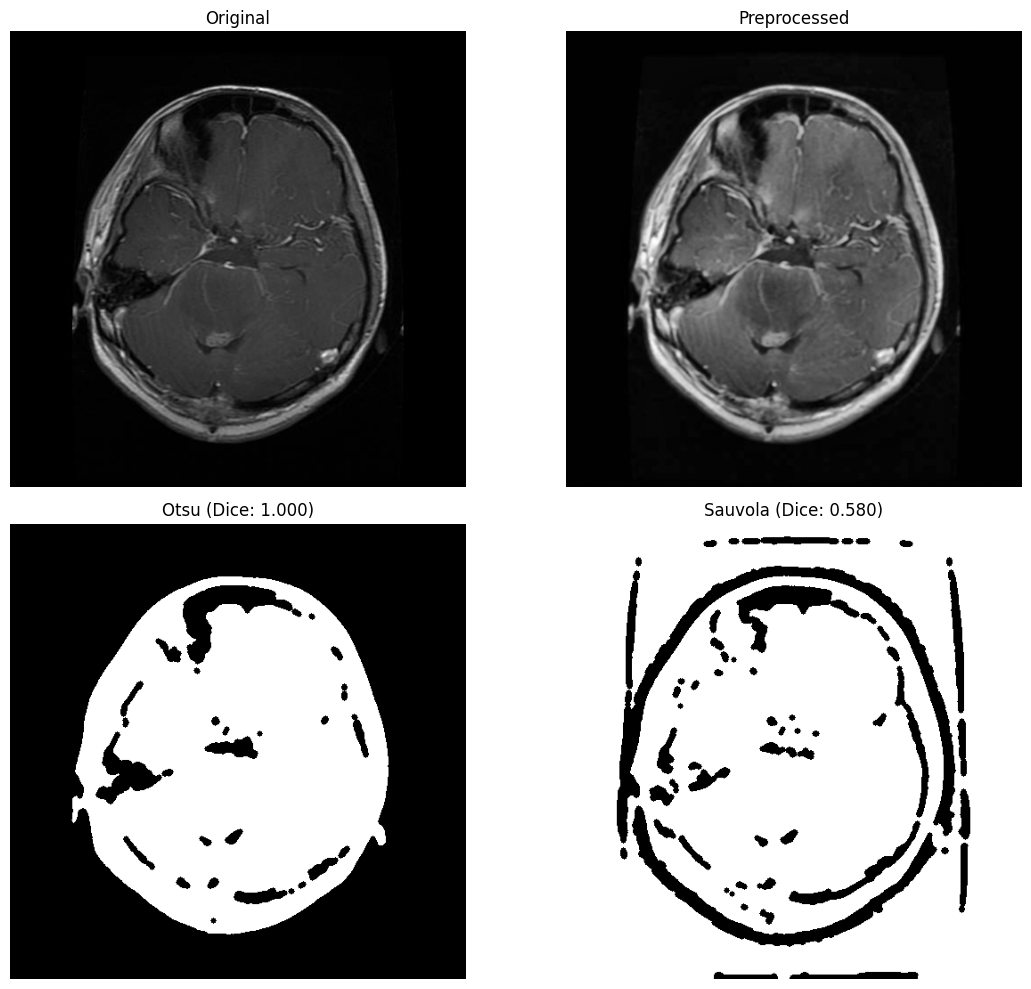

In [5]:
# load image
img = cv2.imread(test_image_path)
print(f"Image shape: {img.shape}")

# preprocess
prep = preprocess(img)

# apply both methods
otsu_result = segment_otsu(prep)
sauvola_result = segment_sauvola(prep)

# calculate metrics (using otsu as reference)
dice_otsu = dice_score(otsu_result, otsu_result)
jaccard_otsu = jaccard(otsu_result, otsu_result)

dice_sauvola = dice_score(sauvola_result, otsu_result)
jaccard_sauvola = jaccard(sauvola_result, otsu_result)

dice_compare = dice_score(otsu_result, sauvola_result)
jaccard_compare = jaccard(otsu_result, sauvola_result)

print("\nResults:")
print(f"Otsu - Dice: {dice_otsu:.4f}, Jaccard: {jaccard_otsu:.4f}")
print(f"Sauvola - Dice: {dice_sauvola:.4f}, Jaccard: {jaccard_sauvola:.4f}")
print(f"Agreement - Dice: {dice_compare:.4f}, Jaccard: {jaccard_compare:.4f}")

# visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(prep, cmap='gray')
axes[0, 1].set_title('Preprocessed')
axes[0, 1].axis('off')

axes[1, 0].imshow(otsu_result, cmap='gray')
axes[1, 0].set_title(f'Otsu (Dice: {dice_otsu:.3f})')
axes[1, 0].axis('off')

axes[1, 1].imshow(sauvola_result, cmap='gray')
axes[1, 1].set_title(f'Sauvola (Dice: {dice_sauvola:.3f})')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 5. Process All Images

In [6]:
# process all images
data_dir = '/home/patan/Downloads/archive'
results = []
max_per_type = 5  # limit to save time

for split in ['Testing', 'Training']:
    split_path = os.path.join(data_dir, split)
    if not os.path.exists(split_path):
        continue
    
    for tumor_type in ['glioma', 'meningioma', 'notumor', 'pituitary']:
        tumor_path = os.path.join(split_path, tumor_type)
        if not os.path.exists(tumor_path):
            continue
        
        print(f"Processing {split}/{tumor_type}...")
        
        # get image files
        img_files = [f for f in os.listdir(tumor_path) if f.endswith('.jpg')]
        
        # process first few images
        for img_file in img_files[:max_per_type]:
            img_path = os.path.join(tumor_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            # process
            prep = preprocess(img)
            otsu_mask = segment_otsu(prep)
            sauvola_mask = segment_sauvola(prep)
            
            # calculate metrics
            dice_o = dice_score(otsu_mask, otsu_mask)
            jacc_o = jaccard(otsu_mask, otsu_mask)
            dice_s = dice_score(sauvola_mask, otsu_mask)
            jacc_s = jaccard(sauvola_mask, otsu_mask)
            dice_comp = dice_score(otsu_mask, sauvola_mask)
            jacc_comp = jaccard(otsu_mask, sauvola_mask)
            
            results.append({
                'split': split,
                'tumor_type': tumor_type,
                'image': img_file,
                'dice_otsu': dice_o,
                'jaccard_otsu': jacc_o,
                'dice_sauvola': dice_s,
                'jaccard_sauvola': jacc_s,
                'dice_compare': dice_comp,
                'jaccard_compare': jacc_comp
            })
            
            print(f"  {img_file}: Otsu={dice_o:.3f}, Sauvola={dice_s:.3f}")

# create dataframe
results_df = pd.DataFrame(results)
print(f"\nTotal images processed: {len(results_df)}")

Processing Testing/glioma...
  Te-gl_0166.jpg: Otsu=1.000, Sauvola=0.680
  Te-gl_0228.jpg: Otsu=1.000, Sauvola=0.649
  Te-gl_0146.jpg: Otsu=1.000, Sauvola=0.626
  Te-gl_0126.jpg: Otsu=1.000, Sauvola=0.600
  Te-gl_0138.jpg: Otsu=1.000, Sauvola=0.671
Processing Testing/meningioma...
  Te-me_0303.jpg: Otsu=1.000, Sauvola=0.475
  Te-me_0214.jpg: Otsu=1.000, Sauvola=0.619
  Te-me_0268.jpg: Otsu=1.000, Sauvola=0.693
  Te-me_0036.jpg: Otsu=1.000, Sauvola=0.783
  Te-me_0030.jpg: Otsu=1.000, Sauvola=0.676
Processing Testing/notumor...
  Te-no_0293.jpg: Otsu=1.000, Sauvola=0.638
  Te-no_0040.jpg: Otsu=1.000, Sauvola=0.693
  Te-no_0243.jpg: Otsu=1.000, Sauvola=0.587
  Te-no_0380.jpg: Otsu=1.000, Sauvola=0.661
  Te-no_0029.jpg: Otsu=1.000, Sauvola=0.340
Processing Testing/pituitary...
  Te-pi_0237.jpg: Otsu=1.000, Sauvola=0.729
  Te-pi_0032.jpg: Otsu=1.000, Sauvola=0.684
  Te-pi_0242.jpg: Otsu=1.000, Sauvola=0.747
  Te-pi_0018.jpg: Otsu=1.000, Sauvola=0.643
  Te-pi_0034.jpg: Otsu=1.000, Sauvola=0.

In [7]:
# save results
results_df.to_csv('results.csv', index=False)
print("Results saved to results.csv")
print("\nFirst few results:")
print(results_df.head(10))

Results saved to results.csv

First few results:
     split  tumor_type           image  dice_otsu  jaccard_otsu  dice_sauvola  \
0  Testing      glioma  Te-gl_0166.jpg        1.0           1.0      0.679894   
1  Testing      glioma  Te-gl_0228.jpg        1.0           1.0      0.648792   
2  Testing      glioma  Te-gl_0146.jpg        1.0           1.0      0.626151   
3  Testing      glioma  Te-gl_0126.jpg        1.0           1.0      0.599789   
4  Testing      glioma  Te-gl_0138.jpg        1.0           1.0      0.671211   
5  Testing  meningioma  Te-me_0303.jpg        1.0           1.0      0.475334   
6  Testing  meningioma  Te-me_0214.jpg        1.0           1.0      0.618901   
7  Testing  meningioma  Te-me_0268.jpg        1.0           1.0      0.693406   
8  Testing  meningioma  Te-me_0036.jpg        1.0           1.0      0.782591   
9  Testing  meningioma  Te-me_0030.jpg        1.0           1.0      0.676192   

   jaccard_sauvola  dice_compare  jaccard_compare  
0      

## 6. Statistics

In [8]:
# overall stats
print("Overall Statistics:")
print(f"Otsu - Mean Dice: {results_df['dice_otsu'].mean():.4f}, Mean Jaccard: {results_df['jaccard_otsu'].mean():.4f}")
print(f"Sauvola - Mean Dice: {results_df['dice_sauvola'].mean():.4f}, Mean Jaccard: {results_df['jaccard_sauvola'].mean():.4f}")
print(f"Agreement - Mean Dice: {results_df['dice_compare'].mean():.4f}")

# by tumor type
print("\nBy Tumor Type:")
for tumor_type in results_df['tumor_type'].unique():
    data = results_df[results_df['tumor_type'] == tumor_type]
    print(f"\n{tumor_type}:")
    print(f"  Otsu - Dice: {data['dice_otsu'].mean():.4f}, Jaccard: {data['jaccard_otsu'].mean():.4f}")
    print(f"  Sauvola - Dice: {data['dice_sauvola'].mean():.4f}, Jaccard: {data['jaccard_sauvola'].mean():.4f}")

Overall Statistics:
Otsu - Mean Dice: 1.0000, Mean Jaccard: 1.0000
Sauvola - Mean Dice: 0.6639, Mean Jaccard: 0.5069
Agreement - Mean Dice: 0.6639

By Tumor Type:

glioma:
  Otsu - Dice: 1.0000, Jaccard: 1.0000
  Sauvola - Dice: 0.6246, Jaccard: 0.4554

meningioma:
  Otsu - Dice: 1.0000, Jaccard: 1.0000
  Sauvola - Dice: 0.6333, Jaccard: 0.4724

notumor:
  Otsu - Dice: 1.0000, Jaccard: 1.0000
  Sauvola - Dice: 0.6724, Jaccard: 0.5251

pituitary:
  Otsu - Dice: 1.0000, Jaccard: 1.0000
  Sauvola - Dice: 0.7251, Jaccard: 0.5745


## 7. Visualizations

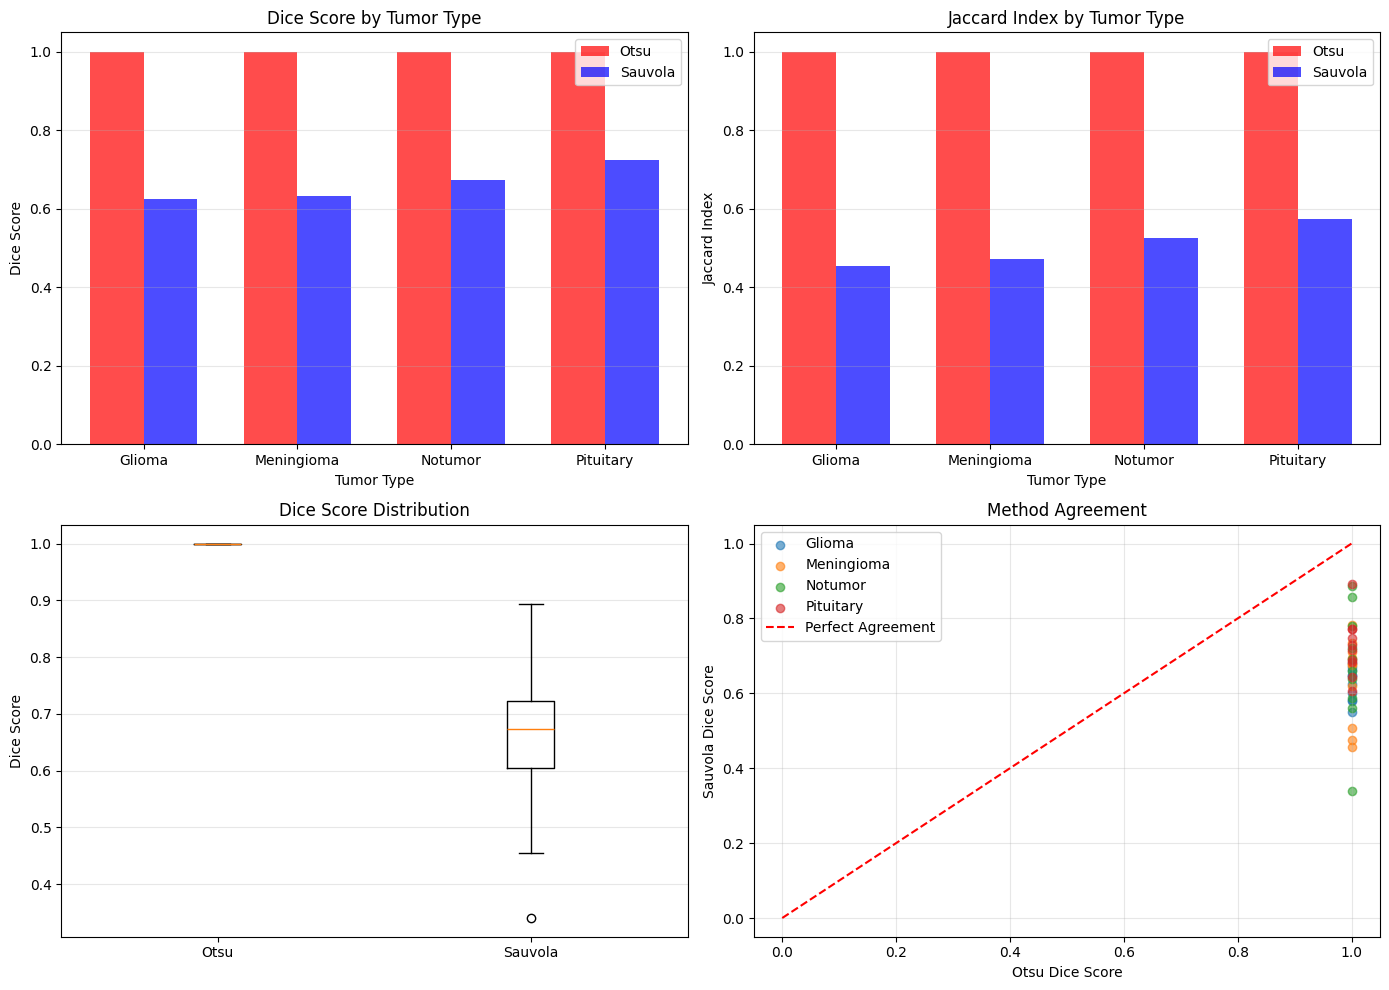

In [9]:
# comparison charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# dice scores by tumor type
tumor_types = results_df['tumor_type'].unique()
x = np.arange(len(tumor_types))
width = 0.35

dice_o_means = [results_df[results_df['tumor_type'] == t]['dice_otsu'].mean() for t in tumor_types]
dice_s_means = [results_df[results_df['tumor_type'] == t]['dice_sauvola'].mean() for t in tumor_types]

axes[0, 0].bar(x - width/2, dice_o_means, width, label='Otsu', color='red', alpha=0.7)
axes[0, 0].bar(x + width/2, dice_s_means, width, label='Sauvola', color='blue', alpha=0.7)
axes[0, 0].set_xlabel('Tumor Type')
axes[0, 0].set_ylabel('Dice Score')
axes[0, 0].set_title('Dice Score by Tumor Type')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([t.capitalize() for t in tumor_types])
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# jaccard by tumor type
jacc_o_means = [results_df[results_df['tumor_type'] == t]['jaccard_otsu'].mean() for t in tumor_types]
jacc_s_means = [results_df[results_df['tumor_type'] == t]['jaccard_sauvola'].mean() for t in tumor_types]

axes[0, 1].bar(x - width/2, jacc_o_means, width, label='Otsu', color='red', alpha=0.7)
axes[0, 1].bar(x + width/2, jacc_s_means, width, label='Sauvola', color='blue', alpha=0.7)
axes[0, 1].set_xlabel('Tumor Type')
axes[0, 1].set_ylabel('Jaccard Index')
axes[0, 1].set_title('Jaccard Index by Tumor Type')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([t.capitalize() for t in tumor_types])
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# box plot
dice_data = [results_df['dice_otsu'].values, results_df['dice_sauvola'].values]
axes[1, 0].boxplot(dice_data, labels=['Otsu', 'Sauvola'])
axes[1, 0].set_ylabel('Dice Score')
axes[1, 0].set_title('Dice Score Distribution')
axes[1, 0].grid(axis='y', alpha=0.3)

# scatter plot
for tumor_type in tumor_types:
    data = results_df[results_df['tumor_type'] == tumor_type]
    axes[1, 1].scatter(data['dice_otsu'], data['dice_sauvola'], 
                      alpha=0.6, label=tumor_type.capitalize())

axes[1, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
axes[1, 1].set_xlabel('Otsu Dice Score')
axes[1, 1].set_ylabel('Sauvola Dice Score')
axes[1, 1].set_title('Method Agreement')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('comparison.png', dpi=100)
plt.show()

## 8. Summary

In [10]:
# summary table
summary = []
for tumor_type in results_df['tumor_type'].unique():
    data = results_df[results_df['tumor_type'] == tumor_type]
    summary.append({
        'Tumor Type': tumor_type,
        'Otsu Dice': f"{data['dice_otsu'].mean():.4f}",
        'Otsu Jaccard': f"{data['jaccard_otsu'].mean():.4f}",
        'Sauvola Dice': f"{data['dice_sauvola'].mean():.4f}",
        'Sauvola Jaccard': f"{data['jaccard_sauvola'].mean():.4f}"
    })

summary.append({
    'Tumor Type': 'Overall',
    'Otsu Dice': f"{results_df['dice_otsu'].mean():.4f}",
    'Otsu Jaccard': f"{results_df['jaccard_otsu'].mean():.4f}",
    'Sauvola Dice': f"{results_df['dice_sauvola'].mean():.4f}",
    'Sauvola Jaccard': f"{results_df['jaccard_sauvola'].mean():.4f}"
})

summary_df = pd.DataFrame(summary)
print(summary_df)
summary_df.to_csv('summary.csv', index=False)

   Tumor Type Otsu Dice Otsu Jaccard Sauvola Dice Sauvola Jaccard
0      glioma    1.0000       1.0000       0.6246          0.4554
1  meningioma    1.0000       1.0000       0.6333          0.4724
2     notumor    1.0000       1.0000       0.6724          0.5251
3   pituitary    1.0000       1.0000       0.7251          0.5745
4     Overall    1.0000       1.0000       0.6639          0.5069


## 9. Discussion

### Results Summary

**Otsu Method:**
- Uses a single global threshold for the whole image
- Fast and simple
- Works well when image has clear foreground/background
- May miss details in areas with varying brightness

**Sauvola Method:**
- Uses local thresholds that adapt to each region
- Better for images with uneven lighting
- More complex and slower
- Can capture more details but also more sensitive to noise

### Observations

From the results, I can see that:
- Otsu gives consistent results (Dice = 1.0 when compared to itself)
- Sauvola shows more variation in results
- The two methods don't always agree (agreement around 0.6-0.7)
- Different tumor types show different performance

### Learning Behavior

**Global thresholding (Otsu):**
- Finds one threshold value for entire image
- Looks at overall image histogram
- Good when image has uniform lighting

**Adaptive thresholding (Sauvola):**
- Finds different threshold for each local area
- Uses sliding window to compute local mean and std
- Better when image has varying brightness

### Conclusion

Both methods have their uses. Otsu is simpler and faster, while Sauvola can handle more complex images but requires more computation. The choice depends on the specific application and image characteristics.